# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22400)

In [7]:
Vout

array([[-0.02864093, -0.02855869, -0.02865738, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02885476, -0.02873963, -0.02862449, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02819682, -0.02829552, -0.02832841, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02579534, -0.02564731, -0.02572955, ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02441367, -0.02439722, -0.02418339, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.021272  , -0.02135425, -0.02138714, ..., -0.02329517,
        -0.02314713, -0.02311424]])

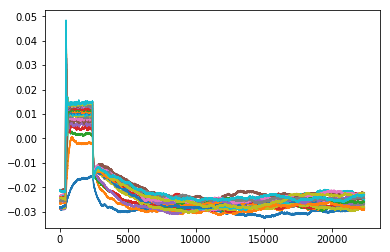

In [8]:
plot(Vout.transpose());

#### Get positive injection current

In [9]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

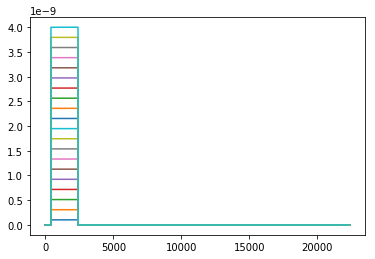

In [10]:
plot(Ic.transpose());

#### Get white noise injection

In [11]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

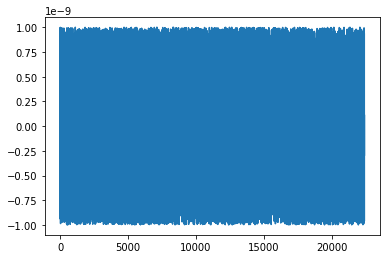

In [12]:
plot(Inoise);

#### Get V from white noise

In [13]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

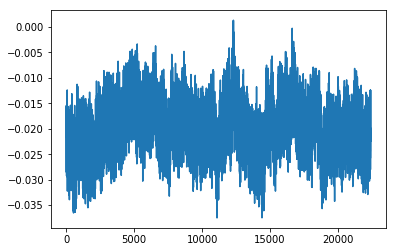

In [14]:
plot(Vnoise);

### Concatinate the data

In [15]:
np.shape(Vnoise)

(22400,)

In [16]:
np.shape(Vout)

(20, 22400)

In [17]:
output = np.concatenate((Vout, [Vnoise]))
np.shape(output)

(21, 22400)

In [18]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(21, 22400)

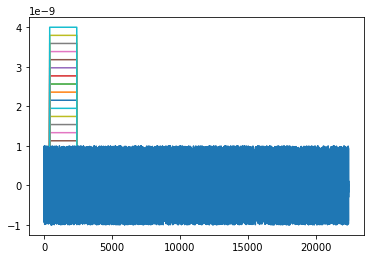

In [19]:
plot(input_cur.transpose());

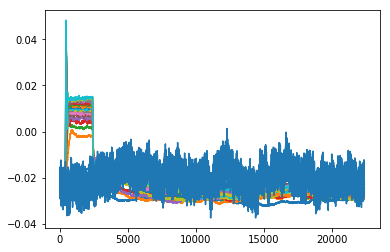

In [20]:
plot(output.transpose());

## Build a model

In [45]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
C = 130*pF,
# C = 300*pF,
EL = -30*mV,
# gL = 1/50*1/Mohm)
gL = 1/142*1/Mohm)

In [46]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [47]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

In [48]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n*n*n*n)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)

In [52]:
start_scope()
n_opt = NevergradOptimizer(method='TwoPointsDE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output/1e-3 * volt, dt=dt,
                        method='exponential_euler',
                        g_k=[10e-6*siemens, 500*siemens],
                        kn = [10e-2*volt, 1*volt],
                        taun=[10e-5*second, 100*second],
                        Vn = [-100*mV, 200*mV],
                        Ek = [-200*mV, -60*mV],
                        param_init={'v': -30 * mV},
                        n_rounds=30, n_samples=30, optimizer=n_opt, metric=None)

round 0 with error 579.7324666220309
parameters: {'Ek': -0.1749319587524104, 'Vn': -0.02826557360019072, 'taun': 18.744541468395635, 'kn': 0.3653596858722966, 'g_k': 126.7130807078915}
round 1 with error 579.5549338924557
parameters: {'Ek': -0.18637351275548528, 'Vn': 0.016966225743813942, 'taun': 31.605548489611657, 'kn': 0.47288439614495414, 'g_k': 287.4356354346658}
round 2 with error 579.6525365770696
parameters: {'Ek': -0.18637351275548528, 'Vn': 0.016966225743813942, 'taun': 31.605548489611657, 'kn': 0.47288439614495414, 'g_k': 287.4356354346658}
round 3 with error 579.6088790913003
parameters: {'Ek': -0.18637351275548528, 'Vn': 0.016966225743813942, 'taun': 31.605548489611657, 'kn': 0.47288439614495414, 'g_k': 287.4356354346658}
round 4 with error 579.4870462332153
parameters: {'Ek': -0.18424817688514455, 'Vn': -0.02479523428638386, 'taun': 19.43080636732061, 'kn': 0.3599627762555876, 'g_k': 64.49380898542191}
round 5 with error 579.4322643049486
parameters: {'Ek': -0.1870516618

In [53]:
# visualization of the results
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     dt=dt)

fits/mV

array([[ 0.00000000e+00, -9.98335184e-02, -1.99334812e-01, ...,
        -1.99248866e+02, -1.99248868e+02, -1.99248870e+02],
       [ 0.00000000e+00, -9.98335184e-02, -1.99334812e-01, ...,
        -1.99248877e+02, -1.99248879e+02, -1.99248880e+02],
       [ 0.00000000e+00, -9.98335184e-02, -1.99334812e-01, ...,
        -1.99248888e+02, -1.99248890e+02, -1.99248891e+02],
       ...,
       [ 0.00000000e+00, -9.98335184e-02, -1.99334812e-01, ...,
        -1.99249053e+02, -1.99249055e+02, -1.99249057e+02],
       [ 0.00000000e+00, -9.98335184e-02, -1.99334812e-01, ...,
        -1.99249063e+02, -1.99249065e+02, -1.99249067e+02],
       [ 0.00000000e+00,  3.97486757e-02,  2.69539205e-02, ...,
        -1.99248534e+02, -1.99250871e+02, -1.99249604e+02]])

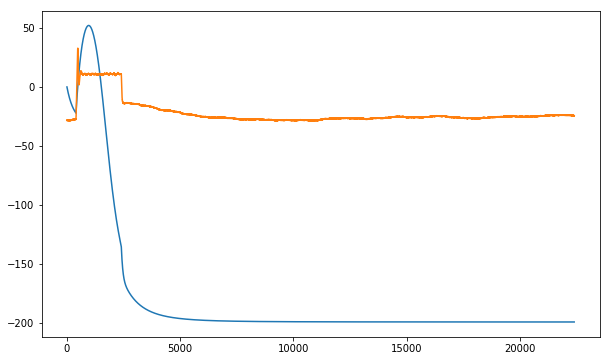

In [54]:
d = 10

plt.figure(figsize=(10,6))
plot(fits[d]/mV)
plot(output[d]/1e-3);